# Install Modules

# Imports

In [2]:
# 1. Basic Python Imports
import pandas as pd
import numpy as np
import pickle as pi
import os
from MCForecastTools import MCSimulation
from pathlib import Path

# 2. API PULL|
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
from defillama import DefiLlama

# 3. API Keys
from dotenv import load_dotenv

# 4. Panadas_Datareader
import pandas_datareader.data as web
from pandas_datareader import data, wb
import pandas_datareader as pdr

# 5. Date Time
import datetime as dt
from datetime import datetime

# 6. Plotting
import plotly
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.pandas 
import hvplot.dask 


In [3]:
# Importing the api

import coinmarketcapapi

cmc = coinmarketcapapi.CoinMarketCapAPI('3486d5cf-6e5b-443f-8f9a-140421f63bb3')

In [4]:
# Changing scientific notation of values in table 

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
# api pull
data_listing = cmc.cryptocurrency_listings_latest(convert='USD')

In [6]:
# create df and narrow columns
df = pd.DataFrame.from_dict(data_listing.data)

df = df[['name', 'symbol', 'date_added', 'quote']]
df

name symbol                date_added  \
0         Bitcoin    BTC  2013-04-28T00:00:00.000Z   
1        Ethereum    ETH  2015-08-07T00:00:00.000Z   
2          Tether   USDT  2015-02-25T00:00:00.000Z   
3        USD Coin   USDC  2018-10-08T00:00:00.000Z   
4             BNB    BNB  2017-07-25T00:00:00.000Z   
..            ...    ...                       ...   
95           Qtum   QTUM  2017-05-24T00:00:00.000Z   
96  1inch Network  1INCH  2020-12-25T00:00:00.000Z   
97           Kava   KAVA  2019-10-25T00:00:00.000Z   
98         Bancor    BNT  2017-06-18T00:00:00.000Z   
99         Symbol    XYM  2021-03-03T00:00:00.000Z   

                                                quote  
0   {'USD': {'price': 28845.028501468278, 'volume_...  
1   {'USD': {'price': 1965.9124892790078, 'volume_...  
2   {'USD': {'price': 0.9980927512958615, 'volume_...  
3   {'USD': {'price': 1.0001406465094338, 'volume_...  
4   {'USD': {'price': 275.0173396925961, 'volume_2...  
..                                                ...  
95  {'USD': {'price': 3.722749569362654, 'volume_2...  
96  {'USD': {'price': 0.932354630513397, 'volume_2...  
97  {'USD': {'price': 1.9899728879512624, 'volume_...  
98  {'USD': {'price': 1.3626171065203982, 'volume_...  
99  {'USD': {'price': 0.06585275055019749, 'volume...  

[100 rows x 4 columns]

In [7]:
# isolate quotes column for expansion into columns
quotes_df = df[['name', 'quote']].copy()
df = df.drop(columns = ['quote'])

In [8]:
# expand into columns
usd = quotes_df["quote"].apply(pd.Series)
price = usd['USD'].apply(pd.Series)

In [9]:
# concat for final df
crypto_df = pd.concat([df, price], axis = 1, join = 'inner')

crypto_df.head(10)

name symbol                date_added     price      volume_24h  \
0      Bitcoin    BTC  2013-04-28T00:00:00.000Z 28845.029 33699088829.987   
1     Ethereum    ETH  2015-08-07T00:00:00.000Z  1965.912 18884584129.336   
2       Tether   USDT  2015-02-25T00:00:00.000Z     0.998 69665356056.963   
3     USD Coin   USDC  2018-10-08T00:00:00.000Z     1.000  6263167512.827   
4          BNB    BNB  2017-07-25T00:00:00.000Z   275.017  2135172814.313   
5          XRP    XRP  2013-08-04T00:00:00.000Z     0.403  2142583681.450   
6  Binance USD   BUSD  2019-09-20T00:00:00.000Z     1.002 12487206797.708   
7      Cardano    ADA  2017-10-01T00:00:00.000Z     0.496  1314623976.706   
8       Solana    SOL  2020-04-10T00:00:00.000Z    47.263  2158424975.884   
9     Dogecoin   DOGE  2013-12-15T00:00:00.000Z     0.086   977092887.587   

   volume_change_24h  percent_change_1h  percent_change_24h  \
0            -33.905             -0.957              -5.863   
1            -34.051             -1.203              -6.960   
2            -32.172             -0.018              -0.100   
3            -40.337              0.003              -0.045   
4            -30.318             -1.965             -10.196   
5            -37.508             -1.002              -9.597   
6             23.718             -0.089               0.152   
7            -41.394             -2.270             -13.352   
8            -31.987             -2.429             -11.323   
9            -50.228             -1.359              -6.935   

   percent_change_7d  percent_change_30d  percent_change_60d  \
0            -19.726             -29.321             -25.219   
1            -26.580             -35.896             -22.187   
2             -0.178              -0.214              -0.219   
3              0.007               0.065               0.044   
4            -26.390             -33.894             -24.416   
5            -32.341             -44.214             -46.582   
6              0.142               0.140               0.301   
7            -36.353             -47.859             -36.964   
8            -41.861             -54.611             -40.771   
9            -33.042             -40.026             -22.766   

   percent_change_90d       market_cap  market_cap_dominance  \
0             -32.145 549199968033.693                44.538   
1             -33.092 237431526345.405                19.260   
2              -0.244  76561849852.880                 6.209   
3               0.051  50887215525.107                 4.127   
4             -32.157  44903999195.798                 3.643   
5             -51.593  19480733609.577                 1.580   
6               0.280  17543700994.679                 1.423   
7             -53.467  16746220181.068                 1.358   
8             -50.959  15942851530.489                 1.293   
9             -44.732  11398544556.029                 0.924   

   fully_diluted_market_cap              last_updated  
0          605745598530.830  2022-05-14T13:50:00.000Z  
1          237431526345.410  2022-05-14T13:49:00.000Z  
2           83553959972.830  2022-05-14T13:49:00.000Z  
3           50887215525.110  2022-05-14T13:49:00.000Z  
4           45409972073.860  2022-05-14T13:49:00.000Z  
5           40296822353.600  2022-05-14T13:50:00.000Z  
6           17543700994.680  2022-05-14T13:50:00.000Z  
7           22335554439.460  2022-05-14T13:49:00.000Z  
8           24180548053.500  2022-05-14T13:49:00.000Z  
9           11398544556.030  2022-05-14T13:50:00.000Z

In [10]:
# Sorting values by largest market cap  

crypto_df.sort_values(by='market_cap', ascending=False).head(10)

name symbol                date_added     price      volume_24h  \
0      Bitcoin    BTC  2013-04-28T00:00:00.000Z 28845.029 33699088829.987   
1     Ethereum    ETH  2015-08-07T00:00:00.000Z  1965.912 18884584129.336   
2       Tether   USDT  2015-02-25T00:00:00.000Z     0.998 69665356056.963   
3     USD Coin   USDC  2018-10-08T00:00:00.000Z     1.000  6263167512.827   
4          BNB    BNB  2017-07-25T00:00:00.000Z   275.017  2135172814.313   
5          XRP    XRP  2013-08-04T00:00:00.000Z     0.403  2142583681.450   
6  Binance USD   BUSD  2019-09-20T00:00:00.000Z     1.002 12487206797.708   
7      Cardano    ADA  2017-10-01T00:00:00.000Z     0.496  1314623976.706   
8       Solana    SOL  2020-04-10T00:00:00.000Z    47.263  2158424975.884   
9     Dogecoin   DOGE  2013-12-15T00:00:00.000Z     0.086   977092887.587   

   volume_change_24h  percent_change_1h  percent_change_24h  \
0            -33.905             -0.957              -5.863   
1            -34.051             -1.203              -6.960   
2            -32.172             -0.018              -0.100   
3            -40.337              0.003              -0.045   
4            -30.318             -1.965             -10.196   
5            -37.508             -1.002              -9.597   
6             23.718             -0.089               0.152   
7            -41.394             -2.270             -13.352   
8            -31.987             -2.429             -11.323   
9            -50.228             -1.359              -6.935   

   percent_change_7d  percent_change_30d  percent_change_60d  \
0            -19.726             -29.321             -25.219   
1            -26.580             -35.896             -22.187   
2             -0.178              -0.214              -0.219   
3              0.007               0.065               0.044   
4            -26.390             -33.894             -24.416   
5            -32.341             -44.214             -46.582   
6              0.142               0.140               0.301   
7            -36.353             -47.859             -36.964   
8            -41.861             -54.611             -40.771   
9            -33.042             -40.026             -22.766   

   percent_change_90d       market_cap  market_cap_dominance  \
0             -32.145 549199968033.693                44.538   
1             -33.092 237431526345.405                19.260   
2              -0.244  76561849852.880                 6.209   
3               0.051  50887215525.107                 4.127   
4             -32.157  44903999195.798                 3.643   
5             -51.593  19480733609.577                 1.580   
6               0.280  17543700994.679                 1.423   
7             -53.467  16746220181.068                 1.358   
8             -50.959  15942851530.489                 1.293   
9             -44.732  11398544556.029                 0.924   

   fully_diluted_market_cap              last_updated  
0          605745598530.830  2022-05-14T13:50:00.000Z  
1          237431526345.410  2022-05-14T13:49:00.000Z  
2           83553959972.830  2022-05-14T13:49:00.000Z  
3           50887215525.110  2022-05-14T13:49:00.000Z  
4           45409972073.860  2022-05-14T13:49:00.000Z  
5           40296822353.600  2022-05-14T13:50:00.000Z  
6           17543700994.680  2022-05-14T13:50:00.000Z  
7           22335554439.460  2022-05-14T13:49:00.000Z  
8           24180548053.500  2022-05-14T13:49:00.000Z  
9           11398544556.030  2022-05-14T13:50:00.000Z

In [11]:
# checking data types

crypto_df['market_cap'].dtypes

dtype('float64')

In [12]:
crypto_df.loc['market_cap'] = crypto_df.loc[:, 'market_cap'].astype("float")

In [14]:
# checking data types

crypto_df.dtypes

name                         object
symbol                       object
date_added                   object
price                       float64
volume_24h                  float64
volume_change_24h           float64
percent_change_1h           float64
percent_change_24h          float64
percent_change_7d           float64
percent_change_30d          float64
percent_change_60d          float64
percent_change_90d          float64
market_cap                  float64
market_cap_dominance        float64
fully_diluted_market_cap    float64
last_updated                 object
dtype: object

In [15]:
# Eliminate the coins under $15B market cap (had to lower this from 25B due to market volatility)  

crypto_df_sorted = crypto_df.loc[crypto_df['market_cap'] >= 15000000000].copy()
crypto_df_sorted.head(10)

name symbol                date_added     price      volume_24h  \
0      Bitcoin    BTC  2013-04-28T00:00:00.000Z 28845.029 33699088829.987   
1     Ethereum    ETH  2015-08-07T00:00:00.000Z  1965.912 18884584129.336   
2       Tether   USDT  2015-02-25T00:00:00.000Z     0.998 69665356056.963   
3     USD Coin   USDC  2018-10-08T00:00:00.000Z     1.000  6263167512.827   
4          BNB    BNB  2017-07-25T00:00:00.000Z   275.017  2135172814.313   
5          XRP    XRP  2013-08-04T00:00:00.000Z     0.403  2142583681.450   
6  Binance USD   BUSD  2019-09-20T00:00:00.000Z     1.002 12487206797.708   
7      Cardano    ADA  2017-10-01T00:00:00.000Z     0.496  1314623976.706   
8       Solana    SOL  2020-04-10T00:00:00.000Z    47.263  2158424975.884   

   volume_change_24h  percent_change_1h  percent_change_24h  \
0            -33.905             -0.957              -5.863   
1            -34.051             -1.203              -6.960   
2            -32.172             -0.018              -0.100   
3            -40.337              0.003              -0.045   
4            -30.318             -1.965             -10.196   
5            -37.508             -1.002              -9.597   
6             23.718             -0.089               0.152   
7            -41.394             -2.270             -13.352   
8            -31.987             -2.429             -11.323   

   percent_change_7d  percent_change_30d  percent_change_60d  \
0            -19.726             -29.321             -25.219   
1            -26.580             -35.896             -22.187   
2             -0.178              -0.214              -0.219   
3              0.007               0.065               0.044   
4            -26.390             -33.894             -24.416   
5            -32.341             -44.214             -46.582   
6              0.142               0.140               0.301   
7            -36.353             -47.859             -36.964   
8            -41.861             -54.611             -40.771   

   percent_change_90d       market_cap  market_cap_dominance  \
0             -32.145 549199968033.693                44.538   
1             -33.092 237431526345.405                19.260   
2              -0.244  76561849852.880                 6.209   
3               0.051  50887215525.107                 4.127   
4             -32.157  44903999195.798                 3.643   
5             -51.593  19480733609.577                 1.580   
6               0.280  17543700994.679                 1.423   
7             -53.467  16746220181.068                 1.358   
8             -50.959  15942851530.489                 1.293   

   fully_diluted_market_cap              last_updated  
0          605745598530.830  2022-05-14T13:50:00.000Z  
1          237431526345.410  2022-05-14T13:49:00.000Z  
2           83553959972.830  2022-05-14T13:49:00.000Z  
3           50887215525.110  2022-05-14T13:49:00.000Z  
4           45409972073.860  2022-05-14T13:49:00.000Z  
5           40296822353.600  2022-05-14T13:50:00.000Z  
6           17543700994.680  2022-05-14T13:50:00.000Z  
7           22335554439.460  2022-05-14T13:49:00.000Z  
8           24180548053.500  2022-05-14T13:49:00.000Z

In [17]:
# Out of the remaining coins, eliminate coins that are newer than 2018 

crypto_df_sorted_2 = crypto_df_sorted.loc[crypto_df_sorted['date_added'] <= '2018-01-01'].copy()
crypto_df_sorted_2.head(10)

name symbol                date_added     price      volume_24h  \
0   Bitcoin    BTC  2013-04-28T00:00:00.000Z 28845.029 33699088829.987   
1  Ethereum    ETH  2015-08-07T00:00:00.000Z  1965.912 18884584129.336   
2    Tether   USDT  2015-02-25T00:00:00.000Z     0.998 69665356056.963   
4       BNB    BNB  2017-07-25T00:00:00.000Z   275.017  2135172814.313   
5       XRP    XRP  2013-08-04T00:00:00.000Z     0.403  2142583681.450   
7   Cardano    ADA  2017-10-01T00:00:00.000Z     0.496  1314623976.706   

   volume_change_24h  percent_change_1h  percent_change_24h  \
0            -33.905             -0.957              -5.863   
1            -34.051             -1.203              -6.960   
2            -32.172             -0.018              -0.100   
4            -30.318             -1.965             -10.196   
5            -37.508             -1.002              -9.597   
7            -41.394             -2.270             -13.352   

   percent_change_7d  percent_change_30d  percent_change_60d  \
0            -19.726             -29.321             -25.219   
1            -26.580             -35.896             -22.187   
2             -0.178              -0.214              -0.219   
4            -26.390             -33.894             -24.416   
5            -32.341             -44.214             -46.582   
7            -36.353             -47.859             -36.964   

   percent_change_90d       market_cap  market_cap_dominance  \
0             -32.145 549199968033.693                44.538   
1             -33.092 237431526345.405                19.260   
2              -0.244  76561849852.880                 6.209   
4             -32.157  44903999195.798                 3.643   
5             -51.593  19480733609.577                 1.580   
7             -53.467  16746220181.068                 1.358   

   fully_diluted_market_cap              last_updated  
0          605745598530.830  2022-05-14T13:50:00.000Z  
1          237431526345.410  2022-05-14T13:49:00.000Z  
2           83553959972.830  2022-05-14T13:49:00.000Z  
4           45409972073.860  2022-05-14T13:49:00.000Z  
5           40296822353.600  2022-05-14T13:50:00.000Z  
7           22335554439.460  2022-05-14T13:49:00.000Z

In [18]:
# Eliminate Stablecoins 

crypto_df_sorted_3 = crypto_df_sorted_2.loc[crypto_df_sorted_2['percent_change_90d'] < -1].copy()
crypto_df_sorted_3.head(10)

name symbol                date_added     price      volume_24h  \
0   Bitcoin    BTC  2013-04-28T00:00:00.000Z 28845.029 33699088829.987   
1  Ethereum    ETH  2015-08-07T00:00:00.000Z  1965.912 18884584129.336   
4       BNB    BNB  2017-07-25T00:00:00.000Z   275.017  2135172814.313   
5       XRP    XRP  2013-08-04T00:00:00.000Z     0.403  2142583681.450   
7   Cardano    ADA  2017-10-01T00:00:00.000Z     0.496  1314623976.706   

   volume_change_24h  percent_change_1h  percent_change_24h  \
0            -33.905             -0.957              -5.863   
1            -34.051             -1.203              -6.960   
4            -30.318             -1.965             -10.196   
5            -37.508             -1.002              -9.597   
7            -41.394             -2.270             -13.352   

   percent_change_7d  percent_change_30d  percent_change_60d  \
0            -19.726             -29.321             -25.219   
1            -26.580             -35.896             -22.187   
4            -26.390             -33.894             -24.416   
5            -32.341             -44.214             -46.582   
7            -36.353             -47.859             -36.964   

   percent_change_90d       market_cap  market_cap_dominance  \
0             -32.145 549199968033.693                44.538   
1             -33.092 237431526345.405                19.260   
4             -32.157  44903999195.798                 3.643   
5             -51.593  19480733609.577                 1.580   
7             -53.467  16746220181.068                 1.358   

   fully_diluted_market_cap              last_updated  
0          605745598530.830  2022-05-14T13:50:00.000Z  
1          237431526345.410  2022-05-14T13:49:00.000Z  
4           45409972073.860  2022-05-14T13:49:00.000Z  
5           40296822353.600  2022-05-14T13:50:00.000Z  
7           22335554439.460  2022-05-14T13:49:00.000Z

In [88]:
# Testing dropping 2 colums

crypto_df_sorted_4 = crypto_df_sorted_3.drop(['volume_24h', 'volume_change_24h'], axis=1)
crypto_df_sorted_4

name symbol                date_added     price  percent_change_1h  \
0   Bitcoin    BTC  2013-04-28T00:00:00.000Z 28845.029             -0.957   
1  Ethereum    ETH  2015-08-07T00:00:00.000Z  1965.912             -1.203   
4       BNB    BNB  2017-07-25T00:00:00.000Z   275.017             -1.965   
5       XRP    XRP  2013-08-04T00:00:00.000Z     0.403             -1.002   
7   Cardano    ADA  2017-10-01T00:00:00.000Z     0.496             -2.270   

   percent_change_24h  percent_change_7d  percent_change_30d  \
0              -5.863            -19.726             -29.321   
1              -6.960            -26.580             -35.896   
4             -10.196            -26.390             -33.894   
5              -9.597            -32.341             -44.214   
7             -13.352            -36.353             -47.859   

   percent_change_60d  percent_change_90d       market_cap  \
0             -25.219             -32.145 549199968033.693   
1             -22.187             -33.092 237431526345.405   
4             -24.416             -32.157  44903999195.798   
5             -46.582             -51.593  19480733609.577   
7             -36.964             -53.467  16746220181.068   

   market_cap_dominance  fully_diluted_market_cap              last_updated  
0                44.538          605745598530.830  2022-05-14T13:50:00.000Z  
1                19.260          237431526345.410  2022-05-14T13:49:00.000Z  
4                 3.643           45409972073.860  2022-05-14T13:49:00.000Z  
5                 1.580           40296822353.600  2022-05-14T13:50:00.000Z  
7                 1.358           22335554439.460  2022-05-14T13:49:00.000Z

In [123]:
# Filtering the dataframe to include only relevant colums

crypto_df_5 = crypto_df_sorted_4.loc[:, ["symbol", "price", "market_cap"]]

crypto_df_5.head()

symbol     price       market_cap
0    BTC 28845.029 549199968033.693
1    ETH  1965.912 237431526345.405
4    BNB   275.017  44903999195.798
5    XRP     0.403  19480733609.577
7    ADA     0.496  16746220181.068

<AxesSubplot:title={'center':'Coinset A Price and Market Cap'}>

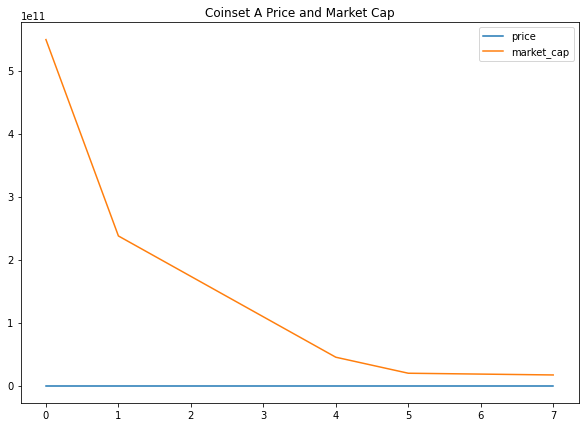

In [22]:
# Testing plot 

crypto_df_5.plot(figsize=(10,7),title="Coinset A Price and Market Cap")

# Next we are finding our DeFi set of coins

In [23]:
# initialize api client|
llama = DefiLlama()

# Get all protocols data
response = llama.get_all_protocols()

# Get a protocol data 
response_1 = llama.get_protocol(name='uniswap')

# Get historical values of total TVL
response_2 = llama.get_historical_tvl()

# Get protocol TVL
response_3 = llama.get_protocol_tvl(name='uniswap')

In [24]:
# Created a DataFrame to structure by relevant parameters

defi_df = pd.DataFrame(response, 
                    columns =[
                        'name',
                        'symbol',
                        'tvl',
                        'fdv',
                        'mcap'
                    ])

defi_df.set_index('name',inplace=True)
defi_df.head()

symbol             tvl            fdv           mcap
name                                                         
MakerDAO    MKR 10213752760.325 1474151813.000 1321300276.000
Curve       CRV  8480483184.508 4262111879.000  505768679.000
Lido        LDO  8468960558.728 1392183085.000  489517339.000
WBTC       WBTC  8268537208.480 8281121966.000 8281121966.000
AAVE       AAVE  8173803815.015 1274742184.000 1092745791.000

In [25]:
# Changing scientific notation of values in table 

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [27]:
# Structuring the DataFrame of the new DeFi coinset 

defi_df1 = pd.DataFrame.from_dict(response)

defi_df1 = defi_df1[['name','symbol', 'tvl', 'fdv', 'mcap']]
defi_df1.set_index('symbol', inplace=True)
defi_df1


name             tvl            fdv           mcap
symbol                                                                  
MKR               MakerDAO 10213752760.325 1474151813.000 1321300276.000
CRV                  Curve  8480483184.508 4262111879.000  505768679.000
LDO                   Lido  8468960558.728 1392183085.000  489517339.000
WBTC                  WBTC  8268537208.480 8281121966.000 8281121966.000
AAVE                  AAVE  8173803815.015 1274742184.000 1092745791.000
...                    ...             ...            ...            ...
PDA              PandaLand           0.000            NaN            NaN
THERMES    Olympus Finance           0.000            NaN            NaN
DEER     ToxicDeer Finance           0.000            NaN            NaN
-             cotiTreasury           0.000            NaN            NaN
NORD          Nord Finance      -27385.924    2489298.000    1237907.000

[1594 rows x 4 columns]

In [ ]:
# Sort by highest TVL's 

defi_df.sort_values(by='tvl', ascending=False).head()

In [28]:
# Reviewing the datatypes

defi_df.dtypes

symbol     object
tvl       float64
fdv       float64
mcap      float64
dtype: object

In [47]:
# Filtering the dataframe to keep the protocols with over $7 Billion in Total Value Locked (TVL values had to be adjusted due to increased volatilty lately) 

defi_df1= defi_df.loc[defi_df['tvl'] > 7000000000].copy()
defi_df1.sort_values(by='mcap', ascending=False).head(10)

symbol             tvl            fdv           mcap
name                                                         
WBTC       WBTC  8268537208.480 8281121966.000 8281121966.000
MakerDAO    MKR 10213752760.325 1474151813.000 1321300276.000
AAVE       AAVE  8173803815.015 1274742184.000 1092745791.000
Curve       CRV  8480483184.508 4262111879.000  505768679.000
Lido        LDO  8468960558.728 1392183085.000  489517339.000

In [126]:
# Filtering the dataframe to keep the protocols with over $10 Billion in Market Cap

defi_df2 = defi_df1.loc[defi_df1['mcap'] > 450000000].copy()
defi_df2.sort_values(by='tvl', ascending=False).head(10)

symbol             tvl            fdv           mcap
name                                                         
MakerDAO    MKR 10213752760.325 1474151813.000 1321300276.000
Curve       CRV  8480483184.508 4262111879.000  505768679.000
Lido        LDO  8468960558.728 1392183085.000  489517339.000
WBTC       WBTC  8268537208.480 8281121966.000 8281121966.000
AAVE       AAVE  8173803815.015 1274742184.000 1092745791.000

In [49]:
# Understanding Fully Diluted Valuation (FDV)

#The Fully Diluted Valuation of a cryptocurrency or token is what the digital asset's market cap would be if all the coins or tokens in its total supply were issued. It’s calculated by
#multiplying the current market price of a particular coin or token with the maximum number of coins there will be.

In [50]:
# Market Cap / Total Value Locked RATIO :

# From a theoretical standpoint, the higher the TVL ratio is, the lower the value of an asset needs to be; however, this is not always the case when 
# we look at reality. One of the easiest ways to implement the TVL ratio is to help determine if a DeFi asset is undervalued or overvalued, and this can be done by looking at the ratio.
# If it is under 1/closer to 0, it is undervalued in most cases. 


In [51]:
# Fully Dilluted Value / Total Value Locked RATIO: 

# Similar to MCAP/TVL , FDV/TVL helps us tell the whole story and is also measured the same. The closer the ratio is to zero, typically the coin is viewed as undervalued. 
#If it is over 1, it may be overvalued. Using both metrics helps provide us with the full picture.  

In [52]:
# Trying to find the most undervalued coins in the DeFi sector by calculating the Market Cap to Total Value Locked Ratio 

defi_df2['mcap_tvl_ratio'] = defi_df2['mcap'] / defi_df2['tvl'] 
defi_df2.sort_values(by='mcap_tvl_ratio', ).head(10)

symbol             tvl            fdv           mcap  mcap_tvl_ratio
name                                                                         
Lido        LDO  8468960558.728 1392183085.000  489517339.000           0.058
Curve       CRV  8480483184.508 4262111879.000  505768679.000           0.060
MakerDAO    MKR 10213752760.325 1474151813.000 1321300276.000           0.129
AAVE       AAVE  8173803815.015 1274742184.000 1092745791.000           0.134
WBTC       WBTC  8268537208.480 8281121966.000 8281121966.000           1.002

In [53]:
# Eliminating the coins with a ratio over 0.5

defi_df3 = defi_df2.loc[defi_df2['mcap_tvl_ratio'] < 0.5].copy()
defi_df3.sort_values(by='tvl', ascending=False).head(10)

symbol             tvl            fdv           mcap  mcap_tvl_ratio
name                                                                         
MakerDAO    MKR 10213752760.325 1474151813.000 1321300276.000           0.129
Curve       CRV  8480483184.508 4262111879.000  505768679.000           0.060
Lido        LDO  8468960558.728 1392183085.000  489517339.000           0.058
AAVE       AAVE  8173803815.015 1274742184.000 1092745791.000           0.134

In [43]:
# Trying to find the most undervalued coins in the DeFi sector by calculating the Fully Diluted Value to Total Value Locked Ratio 

defi_df3['fdv_tvl_ratio'] = defi_df3['fdv'] / defi_df3['tvl']
defi_df3

symbol             tvl            fdv           mcap  mcap_tvl_ratio  \
name                                                                            
MakerDAO    MKR 10213752760.325 1474151813.000 1321300276.000           0.129   
Curve       CRV  8480483184.508 4262111879.000  505768679.000           0.060   
Lido        LDO  8468960558.728 1392183085.000  489517339.000           0.058   
AAVE       AAVE  8173803815.015 1274742184.000 1092745791.000           0.134   

          fdv_tvl_ratio  
name                     
MakerDAO          0.144  
Curve             0.503  
Lido              0.164  
AAVE              0.156

# Now we need to import historical prices for the coins and find price relationship and correlation (variance, cov etc) 

### FUNKY FUNCTIONS

In [57]:


def cn_close_price_dfer(digital_asset=list):
    
    # Date information 
    startdate = datetime(2018,1,1)
    enddate = datetime.today() 
    
    # API PULL to get Data for coins
    adj_close = web.DataReader(digital_asset, 'yahoo',startdate, enddate)
    adj_close_df = adj_close.filter(like="Adj Close")
    adj_close_df.columns = adj_close_df.columns.droplevel(-2)
    
    return(adj_close_df)

In [58]:
def indx_close_price_xls(xlsfile_path=str):
    
    startdate = datetime(2018,1,1)
    
    
    dfs = pd.DataFrame()
    dfs= pd.read_excel(xlsfile_path, skiprows=6).dropna()
    dfs= dfs.rename({'Effective date ':'Date', 'S&P Cryptocurrency Broad Digital Market Index (USD)':'SPCBDM-USD'}, axis='columns')
    dfs= dfs.set_index('Date')
    dfs=dfs.dropna()
  
    return(dfs)

In [59]:
# 1. Our set of coins 
# Based on set parameters as seen in the above code 

string = "-USD"
coin_list = ['BTC','ETH','ADA','BNB','XRP']
coin_list = [s + string for s in coin_list]

coin_list2 = ['CRV','LDO','AAVE','CVX','MKR']
coin_list2 = [s + string for s in coin_list2]

### Getting The Data 

We chose 2018 to get complete data for all coins.

In [60]:
# Get DataFrame of Coinset A
adj_close_df = cn_close_price_dfer(coin_list)

# Get DataFrame of Index/Indices
SPCBDM_path = Path("./Resources/PerformanceGraphExport.xls")
spcbdm_indx = indx_close_price_xls(SPCBDM_path)

spcbdm_indx = spcbdm_indx['2018-01-01':'2022-05-06']
# Concatenate the coin and index dataframes into one df
concat_adj_close_df = pd.concat([adj_close_df, spcbdm_indx], axis=1)

concat_adj_close_df= concat_adj_close_df.dropna()
display(concat_adj_close_df.head())
display(concat_adj_close_df.tail())

BTC-USD  ETH-USD  ADA-USD  BNB-USD  XRP-USD  SPCBDM-USD
Date                                                                
2018-01-01 13657.200  772.641    0.729    8.415    2.391    1653.400
2018-01-02 14982.100  884.444    0.783    8.838    2.481    1855.820
2018-01-03 15201.000  962.720    1.080    9.536    3.105    1935.200
2018-01-04 15599.200  980.922    1.114    9.214    3.197    1931.220
2018-01-05 17429.500  997.720    1.000   14.917    3.049    2040.070

BTC-USD  ETH-USD  ADA-USD  BNB-USD  XRP-USD  SPCBDM-USD
Date                                                                
2022-05-02 38529.328 2857.410    0.782  389.671    0.614    3403.130
2022-05-03 37750.453 2783.476    0.771  383.476    0.605    3336.510
2022-05-04 39698.371 2940.645    0.897  402.503    0.646    3558.930
2022-05-05 36575.141 2749.213    0.791  378.774    0.599    3254.460
2022-05-06 36040.922 2694.980    0.783  379.304    0.603    3229.670

In [62]:
# Calculating the daily returns and dropping all NAN values

daily_returns_1 = concat_adj_close_df.pct_change().dropna()
daily_returns_1.head()

BTC-USD  ETH-USD  ADA-USD  BNB-USD  XRP-USD  SPCBDM-USD
Date                                                               
2018-01-02    0.097    0.145    0.074    0.050    0.038       0.122
2018-01-03    0.015    0.089    0.380    0.079    0.252       0.043
2018-01-04    0.026    0.019    0.032   -0.034    0.029      -0.002
2018-01-05    0.117    0.017   -0.103    0.619   -0.046       0.056
2018-01-08   -0.130    0.151   -0.101    0.224   -0.194      -0.019

In [87]:
# Get DataFrame of Coinset B

adj_close_df2 = cn_close_price_dfer(coin_list2)

# Concatenate the coin and index dataframes into one df

concat_adj_close_df2 = pd.concat([adj_close_df2, spcbdm_indx], axis=1)

concat_adj_close_df2= concat_adj_close_df2.dropna()

#concat_adj_close_df2= concat_adj_close_df2.fillna(0)

display(concat_adj_close_df2.head())
display(concat_adj_close_df2.tail())

CRV-USD  LDO-USD  AAVE-USD  CVX-USD  MKR-USD  SPCBDM-USD
Date                                                                
2021-05-18    3.488    4.056   632.266    9.079 4657.817    4508.390
2021-05-19    1.975    2.436   418.369    6.164 3510.677    3743.390
2021-05-20    2.208    3.161   468.813    7.308 3956.245    3876.760
2021-05-21    1.851    2.217   373.419    5.780 3116.383    3354.100
2021-05-24    1.622    2.368   385.572    6.411 4176.241    3672.130

CRV-USD  LDO-USD  AAVE-USD  CVX-USD  MKR-USD  SPCBDM-USD
Date                                                                
2022-05-02    2.105    2.770   144.047   22.429 1482.810    3403.130
2022-05-03    2.156    2.747   141.099   22.459 1402.082    3336.510
2022-05-04    2.604    3.084   159.080   25.331 1496.008    3558.930
2022-05-05    2.457    2.820   141.561   23.457 1378.030    3254.460
2022-05-06    2.301    2.789   138.379   23.018 1338.703    3229.670

In [85]:
# Concatenate the Coin A and Coin B dataframes into one df

concat_adj_close_df3 = pd.concat([adj_close_df2, adj_close_df], axis=1)
concat_adj_close_df3= concat_adj_close_df3.dropna()
display(concat_adj_close_df3.head())
display(concat_adj_close_df3.tail())

Symbols     CRV-USD  LDO-USD  AAVE-USD  CVX-USD  MKR-USD   BTC-USD  ETH-USD  \
Date                                                                          
2021-05-18    3.488    4.056   632.266    9.079 4657.817 42909.402 3380.070   
2021-05-19    1.975    2.436   418.369    6.164 3510.677 37002.441 2460.679   
2021-05-20    2.208    3.161   468.813    7.308 3956.245 40782.738 2784.294   
2021-05-21    1.851    2.217   373.419    5.780 3116.383 37304.691 2430.621   
2021-05-22    1.625    1.975   334.481    5.657 2767.624 37536.633 2295.706   

Symbols     ADA-USD  BNB-USD  XRP-USD  
Date                                   
2021-05-18    2.004  508.022    1.591  
2021-05-19    1.483  339.025    1.070  
2021-05-20    1.810  393.613    1.186  
2021-05-21    1.552  326.296    1.007  
2021-05-22    1.464  299.504    0.906

Symbols     CRV-USD  LDO-USD  AAVE-USD  CVX-USD  MKR-USD   BTC-USD  ETH-USD  \
Date                                                                          
2022-05-10    1.982    1.971   105.351   21.027 1219.661 31022.906 2343.511   
2022-05-11    1.485    1.522    81.887   13.957 1123.974 28936.355 2072.109   
2022-05-12    1.308    1.412    77.540   11.567 1336.686 29047.752 1961.702   
2022-05-13    1.320    1.485    82.237   12.607 1382.989 29283.104 2014.418   
2022-05-14    1.269    1.346    78.261   11.266 1407.210 28730.836 1959.793   

Symbols     ADA-USD  BNB-USD  XRP-USD  
Date                                   
2022-05-10    0.629  319.327    0.514  
2022-05-11    0.513  269.963    0.413  
2022-05-12    0.474  269.407    0.385  
2022-05-13    0.529  290.584    0.423  
2022-05-14    0.493  273.340    0.399

In [84]:
# Trying to swap the axis - in attempts to get Dataframe in a format to normalize the data 

combined_coin_df = concat_adj_close_df3.swapaxes("index", "columns")
combined_coin_df

Date      2021-05-18  2021-05-19  2021-05-20  2021-05-21  2021-05-22  \
Symbols                                                                
CRV-USD        3.488       1.975       2.208       1.851       1.625   
LDO-USD        4.056       2.436       3.161       2.217       1.975   
AAVE-USD     632.266     418.369     468.813     373.419     334.481   
CVX-USD        9.079       6.164       7.308       5.780       5.657   
MKR-USD     4657.817    3510.677    3956.245    3116.383    2767.624   
BTC-USD    42909.402   37002.441   40782.738   37304.691   37536.633   
ETH-USD     3380.070    2460.679    2784.294    2430.621    2295.706   
ADA-USD        2.004       1.483       1.810       1.552       1.464   
BNB-USD      508.022     339.025     393.613     326.296     299.504   
XRP-USD        1.591       1.070       1.186       1.007       0.906   

Date      2021-05-23  2021-05-24  2021-05-25  2021-05-26  2021-05-27  ...  \
Symbols                                                               ...   
CRV-USD        1.329       1.622       1.612       1.899       1.743  ...   
LDO-USD        1.672       2.368       2.626       2.641       2.334  ...   
AAVE-USD     295.089     385.572     371.380     414.933     369.978  ...   
CVX-USD        5.415       6.411       5.869       7.523       7.910  ...   
MKR-USD     2736.424    4176.241    3865.092    3973.236    3704.653  ...   
BTC-USD    34770.582   38705.980   38402.223   39294.199   38436.969  ...   
ETH-USD     2109.580    2643.591    2706.629    2888.699    2736.489  ...   
ADA-USD        1.325       1.549       1.555       1.783       1.646  ...   
BNB-USD      262.946     345.310     344.114     379.854     367.656  ...   
XRP-USD        0.797       0.993       0.976       1.034       0.970  ...   

Date      2022-05-05  2022-05-06  2022-05-07  2022-05-08  2022-05-09  \
Symbols                                                                
CRV-USD        2.457       2.301       2.235       2.347       1.926   
LDO-USD        2.820       2.789       2.752       2.815       2.026   
AAVE-USD     141.561     138.379     132.256     125.841     100.903   
CVX-USD       23.457      23.018      22.664      21.542      19.301   
MKR-USD     1378.030    1338.703    1266.259    1193.740    1067.376   
BTC-USD    36575.141   36040.922   35501.953   34059.266   30296.953   
ETH-USD     2749.213    2694.980    2636.093    2517.460    2245.430   
ADA-USD        0.791       0.783       0.762       0.740       0.610   
BNB-USD      378.774     379.304     365.684     355.399     299.349   
XRP-USD        0.599       0.603       0.582       0.567       0.493   

Date      2022-05-10  2022-05-11  2022-05-12  2022-05-13  2022-05-14  
Symbols                                                               
CRV-USD        1.982       1.485       1.308       1.320       1.269  
LDO-USD        1.971       1.522       1.412       1.485       1.346  
AAVE-USD     105.351      81.887      77.540      82.237      78.261  
CVX-USD       21.027      13.957      11.567      12.607      11.266  
MKR-USD     1219.661    1123.974    1336.686    1382.989    1407.210  
BTC-USD    31022.906   28936.355   29047.752   29283.104   28730.836  
ETH-USD     2343.511    2072.109    1961.702    2014.418    1959.793  
ADA-USD        0.629       0.513       0.474       0.529       0.493  
BNB-USD      319.327     269.963     269.407     290.584     273.340  
XRP-USD        0.514       0.413       0.385       0.423       0.399  

[10 rows x 362 columns]

### Gearing up for Analysis 

Coinset A

In [83]:
# Variables
yearly_trading_days = 365 # For Crypto

# Data Frames Needed
#    1. Daily Returns
#    2. Average Annual Returns
#    3. Standard Deviation of Daily Returns
#    4. Sharpe Ratios
#    5. Correlation 


# Daily Returns
# Log of percentage change
df_daily_returns = concat_adj_close_df.pct_change()
df_daily_returns = df_daily_returns.dropna()

# Avg Annual Returns
avg_annual_return = df_daily_returns.mean() * yearly_trading_days
avg_annual_return.sort_values()



# Annual Returns STDDEV
df_daily_returns_stddev = df_daily_returns.std() * np.sqrt(yearly_trading_days)
df_daily_returns_stddev.sort_values()



# Sharpe Ratios
sharpe_ratios = avg_annual_return/df_daily_returns_stddev
sharpe_ratios.sort_values()


# Plotting the Sharpe Graphs for Coinset B (DeFi coins)

sharpe_ratios.sort_values().hvplot.bar(
    hover_color='pink',
    title="Coin Portfolio B & SPCBDM Sharpe Ratios"
).opts(
    width=700,
    yformatter='%.0f',
    #color="yellow",
    bgcolor="yellow",
    fontsize={
        'title': 15, 
        'labels': 12, 
    'xticks': 10, 
    'yticks': 10,},
    padding=0.1
)

:Bars   [index]   (0)

<AxesSubplot:title={'center':'Daily Returns of Coinset A vs SPCBDM'}, xlabel='Date'>

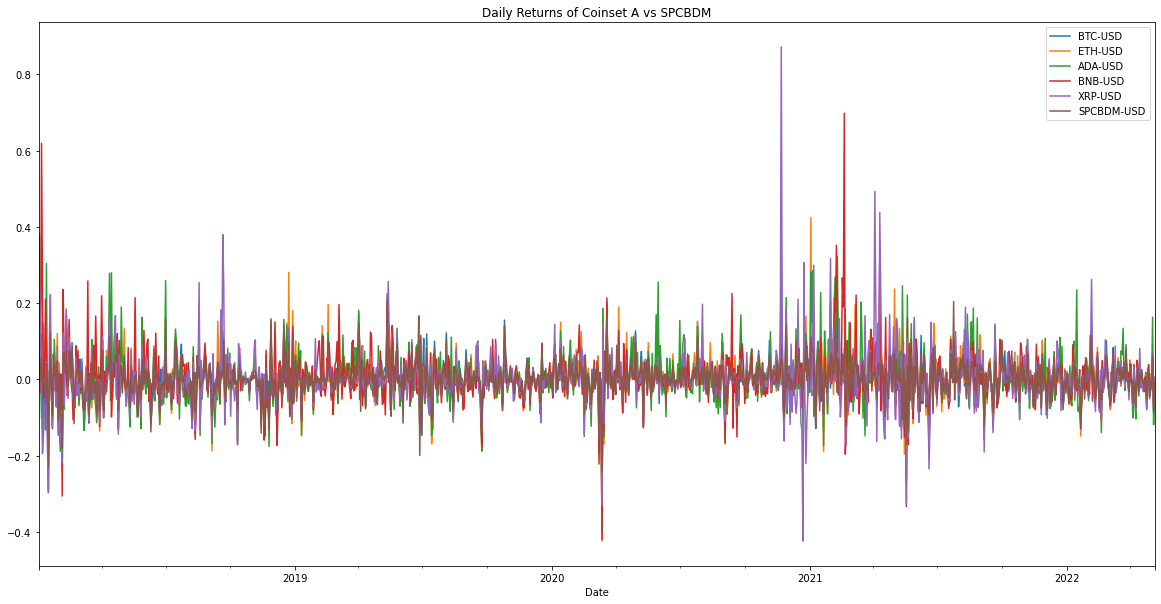

In [71]:
# Plotting the Daily Returns of Coinset A (Veteran Coins) vs the Index 

df_daily_returns.head()
df_daily_returns.plot(figsize=(20, 10), title= "Daily Returns of Coinset A vs SPCBDM")

Coinset B

In [82]:
# Variables
yearly_trading_days = 365 # For Crypto

# Data Frames Needed
#    1. Daily Returns
#    2. Average Annual Returns
#    3. Standard Deviation of Daily Returns
#    4. Sharpe Ratios
#    5. Correlation 


# Daily Returns
# Log of percentage change
df_daily_returns2 = concat_adj_close_df2.pct_change()
df_daily_returns2 = df_daily_returns2.dropna()


# Avg Annual Returns
avg_annual_return2 = df_daily_returns2.mean() * yearly_trading_days
avg_annual_return2.sort_values()


# Annual Returns STDDEV
df_daily_returns_stddev2 = df_daily_returns2.std() * np.sqrt(yearly_trading_days)
df_daily_returns_stddev2.sort_values()


# Sharpe Ratios
sharpe_ratios2 = avg_annual_return2/df_daily_returns_stddev2
sharpe_ratios2.sort_values()


# Plotting the Sharpe Graphs
sharpe_ratios2.sort_values().hvplot.bar(
    hover_color='red',
    title="Coin Portfolio B & SPCBDM Sharpe Ratios"
).opts(
    width=700,
    yformatter='%.0f',
    #color="yellow",
    bgcolor="yellow",
    fontsize={
        'title': 15, 
        'labels': 12, 
    'xticks': 10, 
    'yticks': 10,},
    padding=0.1
)

:Bars   [index]   (0)

<AxesSubplot:title={'center':'Daily Returns of Coinset B vs SPCBDM'}, xlabel='Date'>

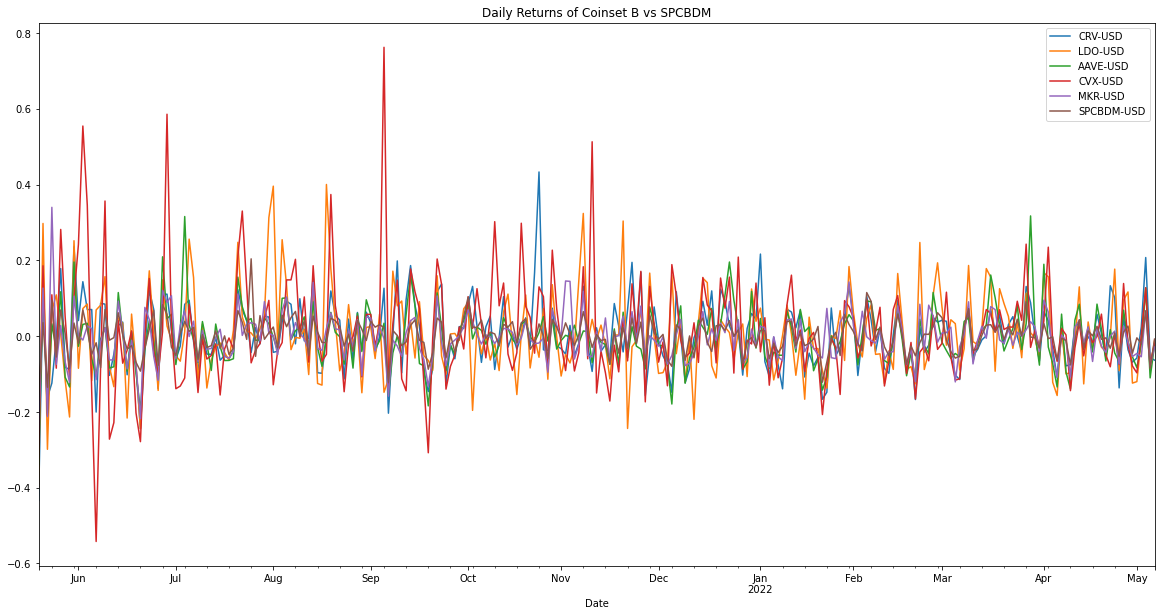

In [70]:
# Plotting the Daily Returns of Coinset A (Veteran Coins) vs the Index 

df_daily_returns2.head()
df_daily_returns2.plot(figsize=(20, 10), title= "Daily Returns of Coinset B vs SPCBDM")

## Brief Note on Correlation

Coinset A

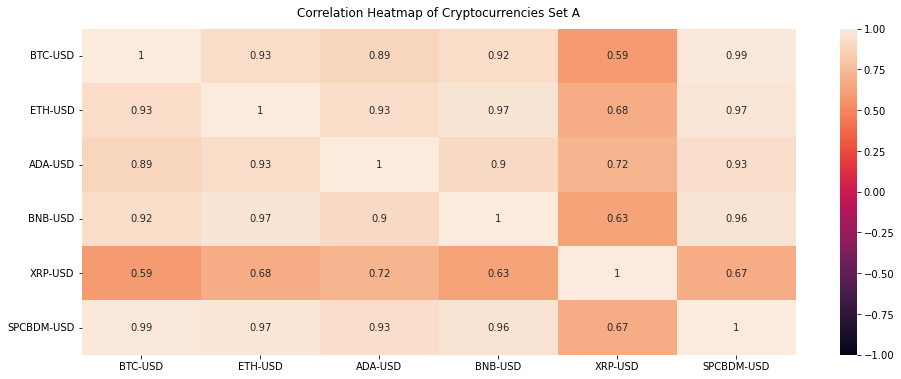

In [81]:
corr_df = concat_adj_close_df.corr(method='pearson')

# reset symbol as index (rather than 0-X)
corr_df.head().reset_index()

# delete corr_df.index.name
corr_df.head(10)

# Plotting heatmap correlation for Coinset A (Veteran Coins)

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap of Cryptocurrencies Set A', fontdict={'fontsize':12}, pad=12);

Coinset B

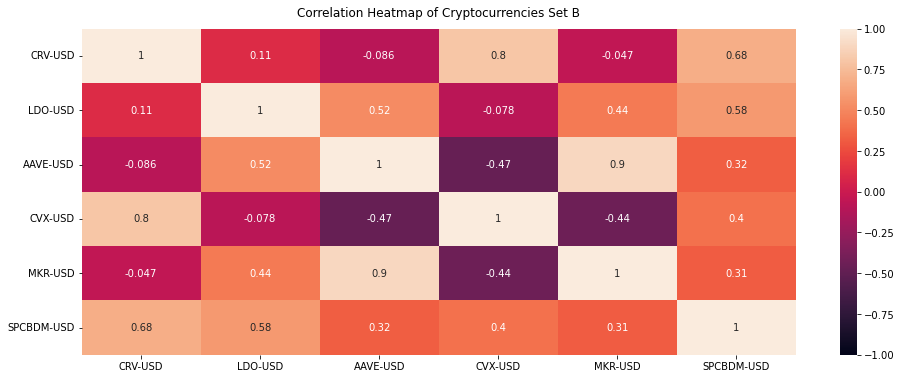

In [80]:
corr_df2 = concat_adj_close_df2.corr(method='pearson')

# reset symbol as index (rather than 0-X)
corr_df2.head().reset_index()

# delete corr_df.index.name
corr_df2.head(10)

# Plotting heatmap correlation for Coinset B (DeFi Coins)

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_df2, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap of Cryptocurrencies Set B', fontdict={'fontsize':12}, pad=12);

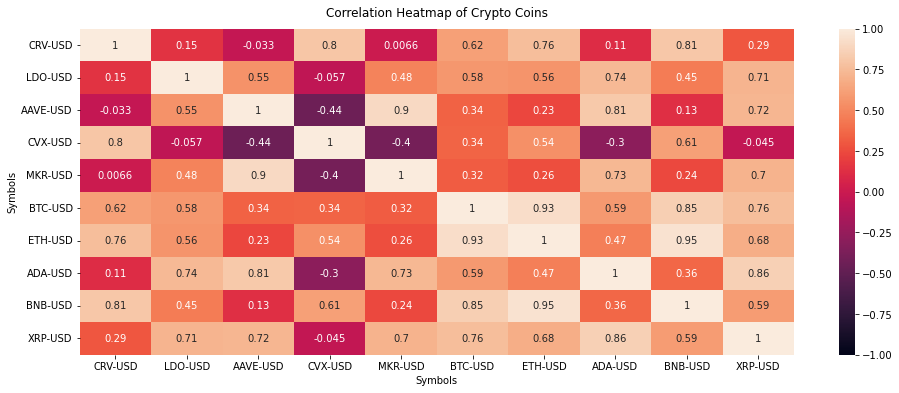

In [79]:
corr_crypto_df = concat_adj_close_df3.corr(method='pearson')

#reset symbol as index (rather than 0-X)
corr_crypto_df.head().reset_index()

#del corr_df.index.name
corr_crypto_df.head(10)

# Plotting heatmap correlation for Coinset A & B 

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_crypto_df, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap of Crypto Coins', fontdict={'fontsize':12}, pad=12);


Measure Cumulative Returns of each Set

Set A

In [90]:
# Calculting the Cumulative Daily Returns for Coinset A (Veteran Coins)

cumulative_dailyrtn = (1 + df_daily_returns).cumprod()
cumulative_dailyrtn.tail()



BTC-USD  ETH-USD  ADA-USD  BNB-USD  XRP-USD  SPCBDM-USD
Date                                                               
2022-05-02    2.821    3.698    1.073   46.309    0.257       2.058
2022-05-03    2.764    3.603    1.058   45.573    0.253       2.018
2022-05-04    2.907    3.806    1.231   47.834    0.270       2.152
2022-05-05    2.678    3.558    1.086   45.014    0.250       1.968
2022-05-06    2.639    3.488    1.075   45.077    0.252       1.953

<AxesSubplot:title={'center':'Cumulative Retruns of Coinset A vs SPCBDM'}, xlabel='Date'>

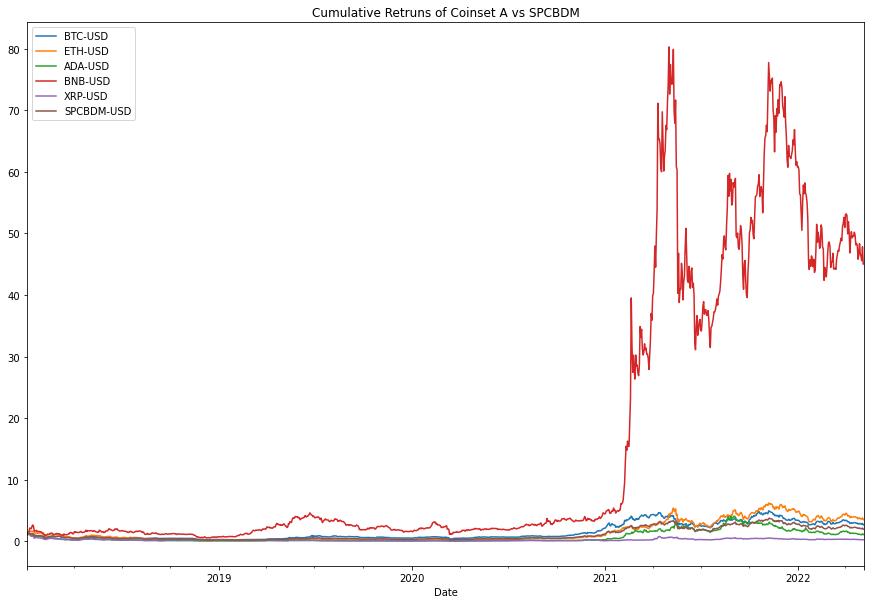

In [91]:
# Plotting the Cumulative Daily Returns for Coinset A (Veteran Coins) vs the Index 

cumulative_dailyrtn.plot(legend="True", figsize=(15, 10), title= "Cumulative Retruns of Coinset A vs SPCBDM")

Set B

In [93]:
# Calculting the cumulative daily returns for Coinset B (DeFi Coins) 

cumulative_dailyrtn2 = (1 + df_daily_returns2).cumprod()
cumulative_dailyrtn2.tail()

CRV-USD  LDO-USD  AAVE-USD  CVX-USD  MKR-USD  SPCBDM-USD
Date                                                                
2022-05-02    0.603    0.683     0.228    2.471    0.318       0.755
2022-05-03    0.618    0.677     0.223    2.474    0.301       0.740
2022-05-04    0.747    0.760     0.252    2.790    0.321       0.789
2022-05-05    0.704    0.695     0.224    2.584    0.296       0.722
2022-05-06    0.660    0.688     0.219    2.535    0.287       0.716

<AxesSubplot:title={'center':'Cumulative Retruns of Coinset B vs SPCBDM'}, xlabel='Date'>

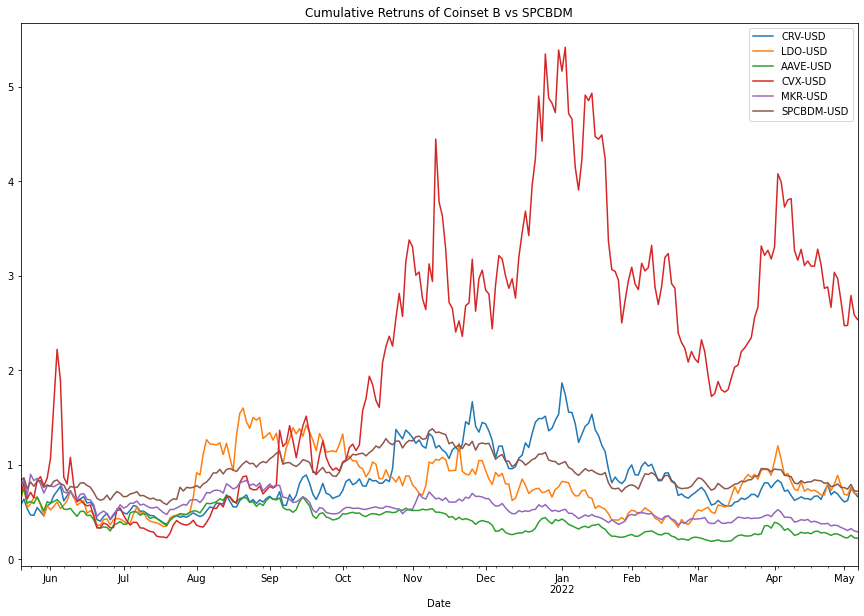

In [94]:
# Plotting the Cumulative Daily Returns for Coinset B (DeFi Coins)

cumulative_dailyrtn2.plot(legend="True", figsize=(15, 10), title= "Cumulative Retruns of Coinset B vs SPCBDM")

# Measure Volatility of each Set vs Index

In [101]:
# Calculating the Standard Deviation for Coinset A (Veteran Coins)

std_pfA = df_daily_returns.std().sort_values()
std_pfA

BTC-USD      0.046
SPCBDM-USD   0.047
ETH-USD      0.060
BNB-USD      0.069
ADA-USD      0.071
XRP-USD      0.073
dtype: float64

In [97]:
# Confirming that the values are sorted in order

df_daily_returns_stddev.sort_values()

BTC-USD      0.871
SPCBDM-USD   0.896
ETH-USD      1.141
BNB-USD      1.323
ADA-USD      1.355
XRP-USD      1.402
dtype: float64

<AxesSubplot:title={'center':'Daily Volatility of Set A vs SPCBDM'}>

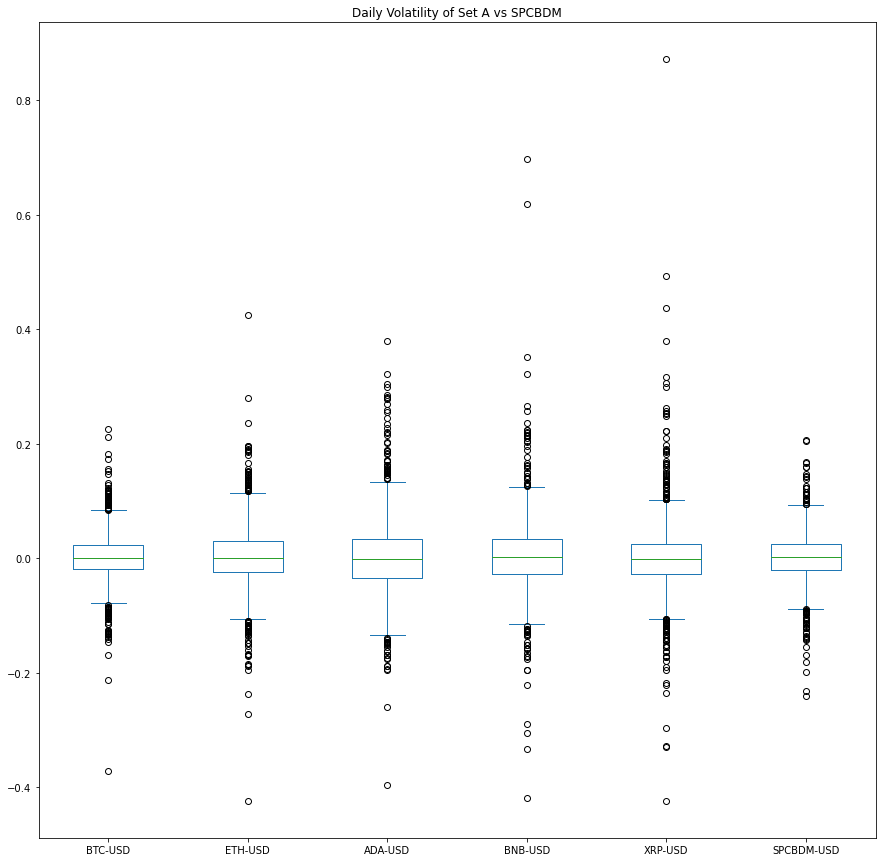

In [98]:
# Plotting the Volatilty of Coinset A vs the SPCBDM index 

df_daily_returns.plot(kind="box", legend="True", figsize=(15, 15), title= "Daily Volatility of Set A vs SPCBDM")

In [100]:
# Calculating the Standard Deviation for Coinset B (DeFi Coins)

std_pfB = df_daily_returns2.std().sort_values()
std_pfB

SPCBDM-USD   0.045
MKR-USD      0.064
AAVE-USD     0.078
CRV-USD      0.092
LDO-USD      0.114
CVX-USD      0.142
dtype: float64

In [102]:
# Confirming that the values are sorted in order

df_daily_returns_stddev2.sort_values()

SPCBDM-USD   0.868
MKR-USD      1.229
AAVE-USD     1.499
CRV-USD      1.761
LDO-USD      2.181
CVX-USD      2.710
dtype: float64

<AxesSubplot:title={'center':'Daily Volatility of Set B vs SPCBDM'}>

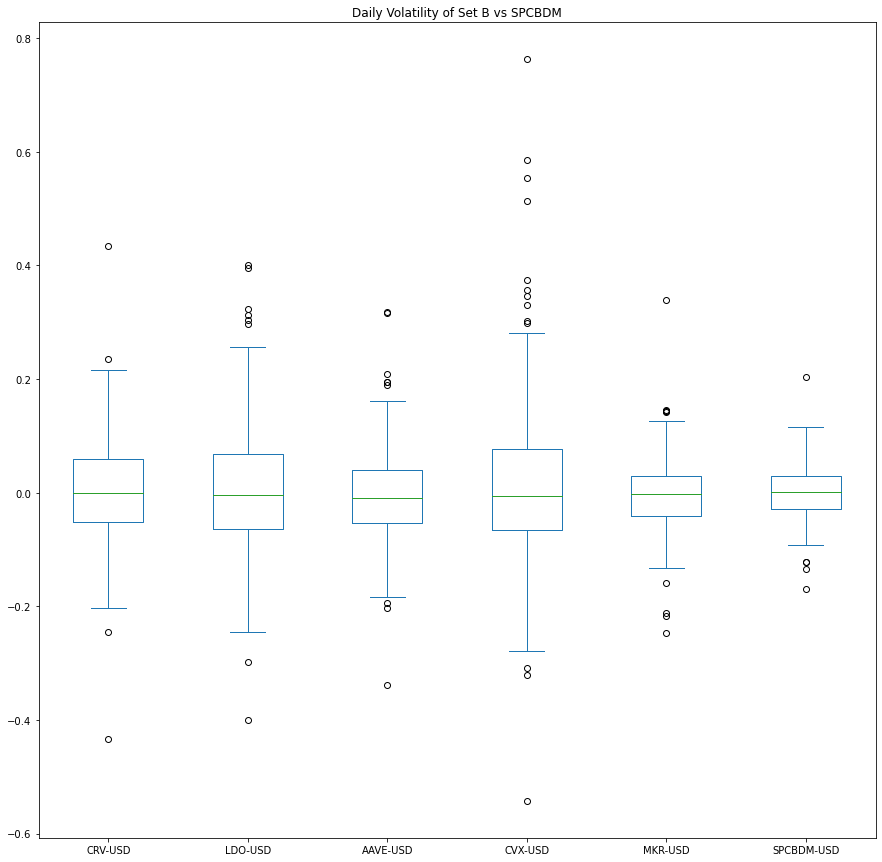

In [103]:
# Plotting the Volatilty of Coinset A vs the SPCBDM index 

df_daily_returns2.plot(kind="box", legend="True", figsize=(15, 15), title= "Daily Volatility of Set B vs SPCBDM")

<AxesSubplot:title={'center':'21-Day Rolling Std Deviation Set A'}, xlabel='Date'>

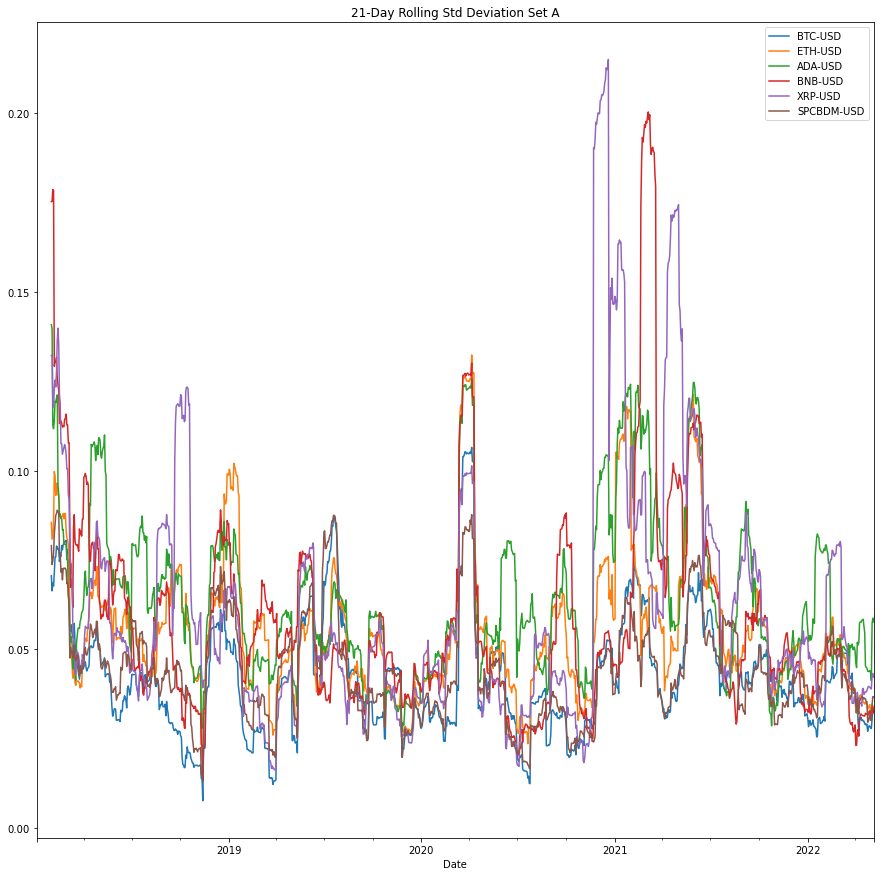

In [104]:
# Plotting the 21 Day Rolling Standard Deviation for Coinset A (Veteran Coins)

df_daily_returns.rolling(window=21).std().plot(legend="True", figsize=(15, 15), title= "21-Day Rolling Std Deviation Set A")

<AxesSubplot:title={'center':'21-Day Rolling Std Deviation Set B'}, xlabel='Date'>

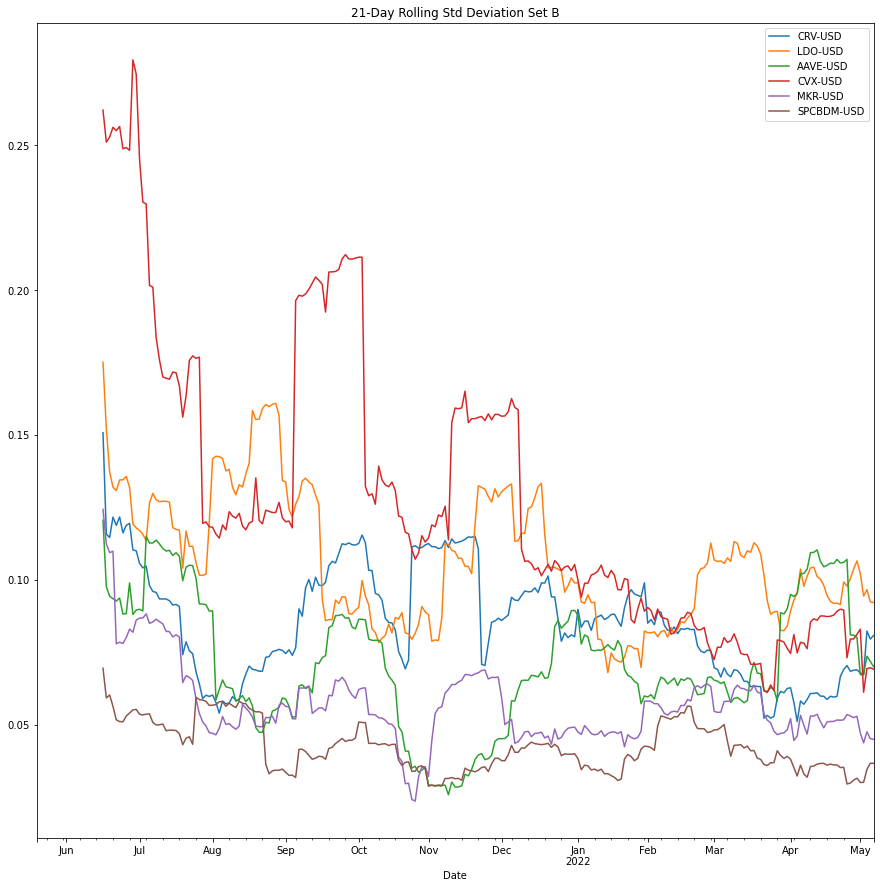

In [106]:
# Plotting the 21 Day Rolling Standard Deviation for Coinset B (DeFi Coins)

df_daily_returns2.rolling(window=21).std().plot(legend="True", figsize=(15, 15), title= "21-Day Rolling Std Deviation Set B")

# For presentation 
Based on the annualized standard deviation, which Coinset pose more risk than the SPCBDM?

Based on the rolling metrics, does the risk of each portfolio increase at the same time that the risk of the SPCBDM increases?


# For Lucas
The dropna situation 

normalizing / unifying the data into a single variable (CoinsetA, CoinsetB)


# For david: 
1.We need to normalize each coin set

2.We need to consolidate them to act as a single line in a plot chart (ex: like an etf equal weight), so we can chart Coinset A/B vs index,
And coinset A+B vs index, and distribute weight




# Now we calculate the daily returns of our set of coins vs the SPCBDM Index

In [115]:
# Calculating the Daily Returns of Coinset A (Veteran Coins) vs the Index. Dropping all NAN values 

daily_returns_1 = concat_adj_close_df.pct_change().dropna()
daily_returns_1.head()

BTC-USD  ETH-USD  ADA-USD  BNB-USD  XRP-USD  SPCBDM-USD
Date                                                               
2018-01-02    0.097    0.145    0.074    0.050    0.038       0.122
2018-01-03    0.015    0.089    0.380    0.079    0.252       0.043
2018-01-04    0.026    0.019    0.032   -0.034    0.029      -0.002
2018-01-05    0.117    0.017   -0.103    0.619   -0.046       0.056
2018-01-08   -0.130    0.151   -0.101    0.224   -0.194      -0.019

<AxesSubplot:title={'center':'Daily Returns of CoinsetA vs SPCBDM'}, xlabel='Date'>

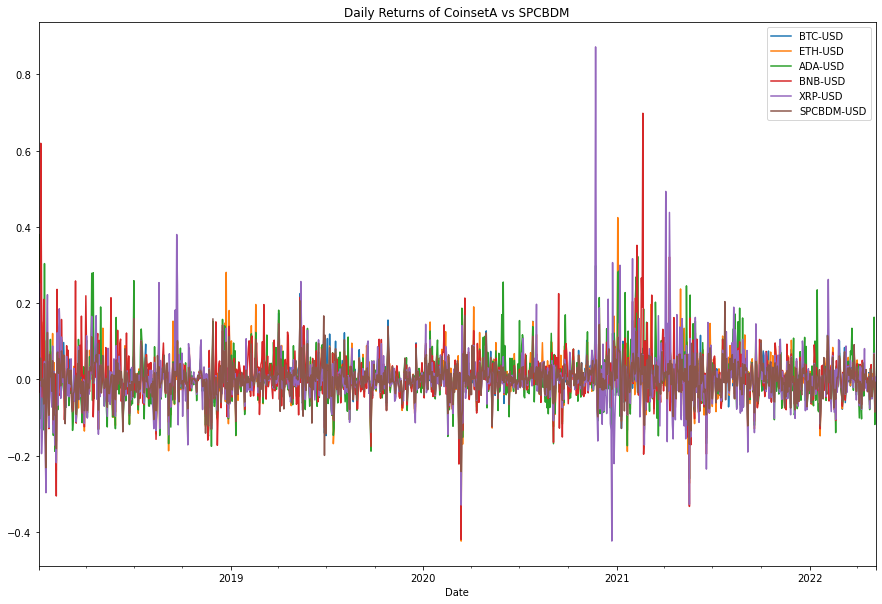

In [108]:
# Plotting the Daily Returns of Coinset A (Veteran Coins) vs the Index 

daily_returns_1.plot(figsize=(15, 10), title= "Daily Returns of CoinsetA vs SPCBDM")

In [109]:
# Calculating the Cumulative Returns for Coinset A (Veteran Coins) vs the Index 

cumulative_dailyrtn = (1 + daily_returns_1).cumprod()
cumulative_dailyrtn.tail()


BTC-USD  ETH-USD  ADA-USD  BNB-USD  XRP-USD  SPCBDM-USD
Date                                                               
2022-05-02    2.821    3.698    1.073   46.309    0.257       2.058
2022-05-03    2.764    3.603    1.058   45.573    0.253       2.018
2022-05-04    2.907    3.806    1.231   47.834    0.270       2.152
2022-05-05    2.678    3.558    1.086   45.014    0.250       1.968
2022-05-06    2.639    3.488    1.075   45.077    0.252       1.953

<AxesSubplot:title={'center':'Cumulative Retruns of Coinset A vs SPCBDM'}, xlabel='Date'>

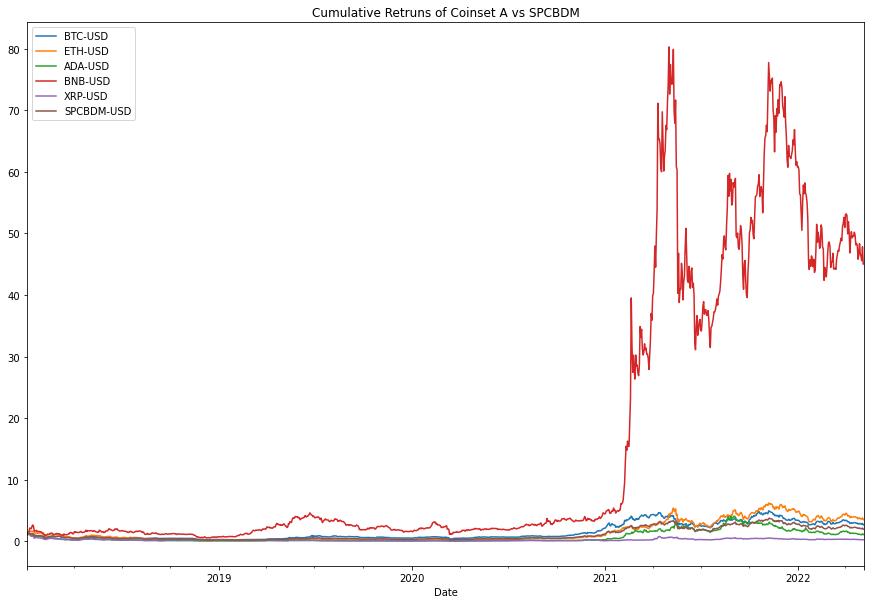

In [110]:
# Plotting the Cumulative Returns for Coinset A vs the Index 

cumulative_dailyrtn.plot(legend="True", figsize=(15, 10), title= "Cumulative Retruns of Coinset A vs SPCBDM")

# Our coins show that they would have outperformed the index, partly due to BNB's run up during 2021. 

In [111]:
# Calculating the average annual return for Coinset A (Veteran Coins)

avg_anl_rtn = daily_returns_1.mean() * 252
avg_anl_rtn.sort_values()

XRP-USD      0.338
SPCBDM-USD   0.429
BTC-USD      0.482
ADA-USD      0.638
ETH-USD      0.732
BNB-USD      1.430
dtype: float64

# BTC , ADA, ETH, BNB all offered better returns than the index! 

In [113]:
# Confirming the datatypes of Coinset A

avg_anl_rtn.dtypes

dtype('float64')

In [ ]:
#def check_value(df = pd.DataFrame()):
    
 #   (df.loc[1] , SPCBDM-USD):
  #  if avg_anl_rtn.loc[1] > SPCBDM-USD :
   #     print("good")
    #elif avg_anl_rtn.loc[1] < SPCBDM-USD:
     #   print("bad")

        
#        for value in avg_anl_rtn:
 #   if coin in avg_anl_rtn > SPCBDM-USD:
  #      print("good")
   # else:
    #    print("bad")


In [114]:
# Calculating the Daily Returns of Coinset A (Veteran Coins) vs the Index . Dropping all NAN values 

daily_returns_2 = concat_adj_close_df2.pct_change().dropna()
daily_returns_2.head()

CRV-USD  LDO-USD  AAVE-USD  CVX-USD  MKR-USD  SPCBDM-USD
Date                                                                
2021-05-19   -0.434   -0.399    -0.338   -0.321   -0.246      -0.170
2021-05-20    0.118    0.298     0.121    0.186    0.127       0.036
2021-05-21   -0.161   -0.299    -0.203   -0.209   -0.212      -0.135
2021-05-24   -0.124    0.068     0.033    0.109    0.340       0.095
2021-05-25   -0.007    0.109    -0.037   -0.084   -0.075      -0.055

<AxesSubplot:title={'center':'Daily Returns of CoinsetB vs SPCBDM'}, xlabel='Date'>

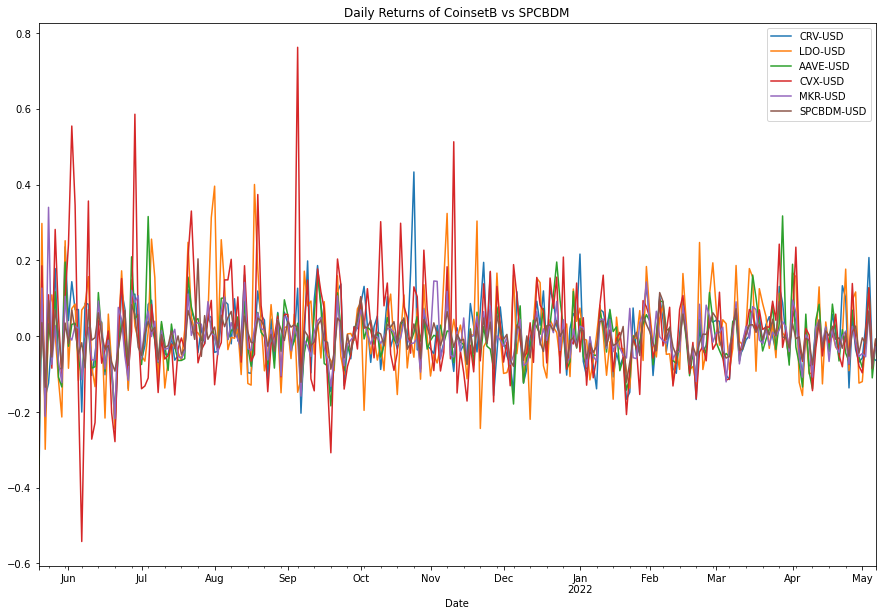

In [120]:
# Plotting the Daily Returns of Coinset B (DeFi Coins) vs the Index 

daily_returns_2.plot(figsize=(15, 10), title= "Daily Returns of CoinsetB vs SPCBDM")

In [119]:
# Calculating the Cumulative Returns of Coinset B (DeFi Coins) vs the Index

cumulative_dailyrtn2 = (1 + daily_returns_2).cumprod()
cumulative_dailyrtn2.tail()


CRV-USD  LDO-USD  AAVE-USD  CVX-USD  MKR-USD  SPCBDM-USD
Date                                                                
2022-05-02    0.603    0.683     0.228    2.471    0.318       0.755
2022-05-03    0.618    0.677     0.223    2.474    0.301       0.740
2022-05-04    0.747    0.760     0.252    2.790    0.321       0.789
2022-05-05    0.704    0.695     0.224    2.584    0.296       0.722
2022-05-06    0.660    0.688     0.219    2.535    0.287       0.716

<AxesSubplot:title={'center':'Cumulative Retruns of Coinset A vs SPCBDM'}, xlabel='Date'>

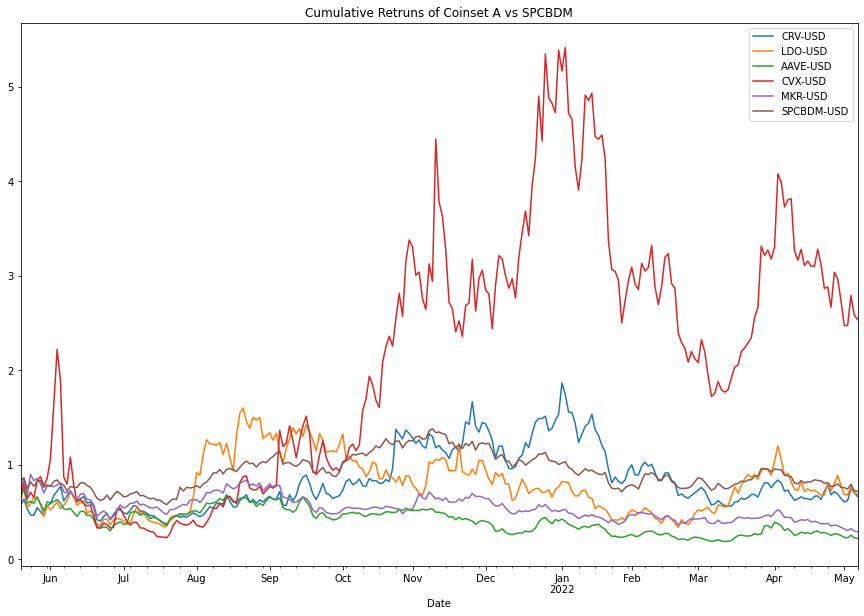

In [118]:
# Plotting the Cumulative Returns of Coinset B (DeFi Coins) vs the Index


cumulative_dailyrtn2.plot(legend="True", figsize=(15, 10), title= "Cumulative Retruns of Coinset A vs SPCBDM")

In [122]:
# Calculating the Average annual return of the DeFi set of coins

avg_anl_rtn2 = daily_returns_2.mean() * 252
avg_anl_rtn2.sort_values()

AAVE-USD     -0.734
MKR-USD      -0.718
SPCBDM-USD   -0.072
CRV-USD       0.673
LDO-USD       1.239
CVX-USD       3.320
dtype: float64

# CURVE , LIDO and CONVEX FINANCE offered a better return that the index! 

In [ ]:
# Creating a dataframe with the final selection of coins that outperformed the index 

coinset_list3 = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'BNB-USD', 'CRV-USD', 'CVX-USD', 'LDO-USD'] 

final_list = cn_close_price_dfer(coinset_list3)

concat_final = pd.concat([final_list, spcbdm_indx], axis=1)
concat_final.dropna()

# THIS IS CURRENTLY OUT OF SCOPE

In [ ]:
Coinset_A_Data = crypto_df_sorted_3[['price']]
Coinset_A_Data

In [ ]:
Coinset_A_Data = Coinset_A_Data.apply(lambda x: (x - x.min(axis=0) ) / (x.max(axis=0) - x.min(axis=0)))

In [ ]:
Coinset_A_Data

In [ ]:
Coinset_A_Data.plot.bar(title="Yo")

In [ ]:
Coinset_B_Data = defi_df3[['tvl']]
Coinset_B_Data

In [ ]:
Coinset_B_Data = Coinset_B_Data.apply(lambda x: (x - x.min(axis=0) ) / (x.max(axis=0) - x.min(axis=0)))

In [ ]:
Coinset_B_Data

In [ ]:
Coinset_B_Data.plot(title="")

In [ ]:
Coinset_C_Data = combined_coin_df

In [ ]:
Coinset_C_Data

In [ ]:
Coinset_C_Data = Coinset_C_Data.apply(lambda x: (x - x.min(axis=0) ) / (x.max(axis=0) - x.min(axis=0)))

In [ ]:
Coinset_C_Data

In [ ]:
Coinset_C_Data.plot(title="")